# Plain English description

Here we explain the contents of this notebook for a non-coding audience, breaking down each part of the process according to our 5-step machine learning roadmap (described in the main text of the paper). <br>

### (1) Identify the materials question of interest
The question here is whether we can predict the power output from a MAPI solar cell device based on the incident light intensity and ambient temperature. These predictions would allow us to estimate how well the device would perform in various locations and environments.

### (2) Obtain sufficient data for model training
We use data from the publication: Tress, W., et al. Performance of perovskite solar cells under simulated temperature-illumination real-world operating conditions. Nature Energy 4, 568-574, doi:10.1038/s41560-019-0400-8 (2019). The authors collect solar cell data over a long time frame (500+ hours), which provides sufficient data to train a simple recurrent neural network, in this case an Echo State Network (ESN).

### (3) Data pre-processing
Information about the raw data: <br>
 - In total: 106920 data points, taken approximately 10 seconds apart <br>
 
The pre-processing steps are as follows: <br>
 - Create a pandas dataframe and load the data <br>
 - Extract three variables of interest from the data, which serve as the model inputs (intensity, temperature) and output (power) <br>
 - Scale the values for each variable from -1 to 1 (since ML algorithms are sensitive to the relative scale of the features) <br>
 - Split the data into train and test sets

### (4) Feature engineering
We do not use feature engineering in this case. 

### (5) Model optimization and testing
The model is constructed using the pyESN implementation of the ESN algorithm (https://github.com/cknd/pyESN). The hyperparameters are set to typical values and not tuned in this case. Therefore, we do not include a validation set and instead split the data in 20% training and 80% testing sets. We can use a small training set for this project since there is a known physical correlation between light intensity and power output for solar cells. This is a simple example of how physics domain knowledge can be incorporated into ML.

The ESN predicts the solar cell power from intensity and temperature with an NRMSE of 3.1%.

# Import the required packages

In [1]:
from collections import OrderedDict
from glob import glob
from datetime import datetime, timedelta
import itertools
import random
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import os
import seaborn as sns
import string

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
    
plot_font_dict = {'fontname':'Arial'}

# Error metric is normalized root mean square error (NRMSE)
def NRMSE(yhat, y):
    num = np.sqrt(np.mean((yhat.flatten() - y.flatten())**2))
    den = max(y) - min(y)
    return num / den

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Data preprocessing

In [3]:
# Load raw data
data_fpath = "/.../" # SET FILE PATH HERE
df = pd.read_csv(data_fpath, sep='\t', skiprows=0)


# Create scaler functions and normalize the data
power_scaler = MinMaxScaler(feature_range=(-1, 1))
temp_scaler = MinMaxScaler(feature_range=(-1, 1))
intensity_scaler = MinMaxScaler(feature_range=(-1, 1))

df[['power']] = power_scaler.fit_transform(df[['power']])
df[['temperature']] = temp_scaler.fit_transform(df[['temperature']])
df[['intensity']] = intensity_scaler.fit_transform(df[['intensity']])

scaled = df.values

X = scaled[:, 2:] 
y = scaled[:, 1]

# Split into train and test sets
# No val set since we are not tuning hyperparameters in this case
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.80, random_state=42, shuffle = False)

# Import the Echo State Network code (from github)

In [4]:
# Using pyESN implementation of the ESN algorithm. Download from https://github.com/cknd/pyESN
from pyESN import ESN

# Train the ESN

In [5]:
# Create ESN. Hyperparameters are pre-set
esn = ESN(n_inputs = 2, 
          n_outputs = 1, 
          n_reservoir = 200, 
          spectral_radius = 1.5,
          sparsity=0.0,
          noise=0.001,
          random_state=42) 

pred_training = esn.fit(trainX, trainY) # ESN training
prediction = esn.predict(testX) # ESN predictions on the test set

power_prediction = power_scaler.inverse_transform(prediction)
test_power = power_scaler.inverse_transform(testY.reshape(-1, 1))

print('NRMSE (%):', NRMSE(power_prediction, test_power) * 100)

NRMSE (%): [3.08118283]


# Visualize the results

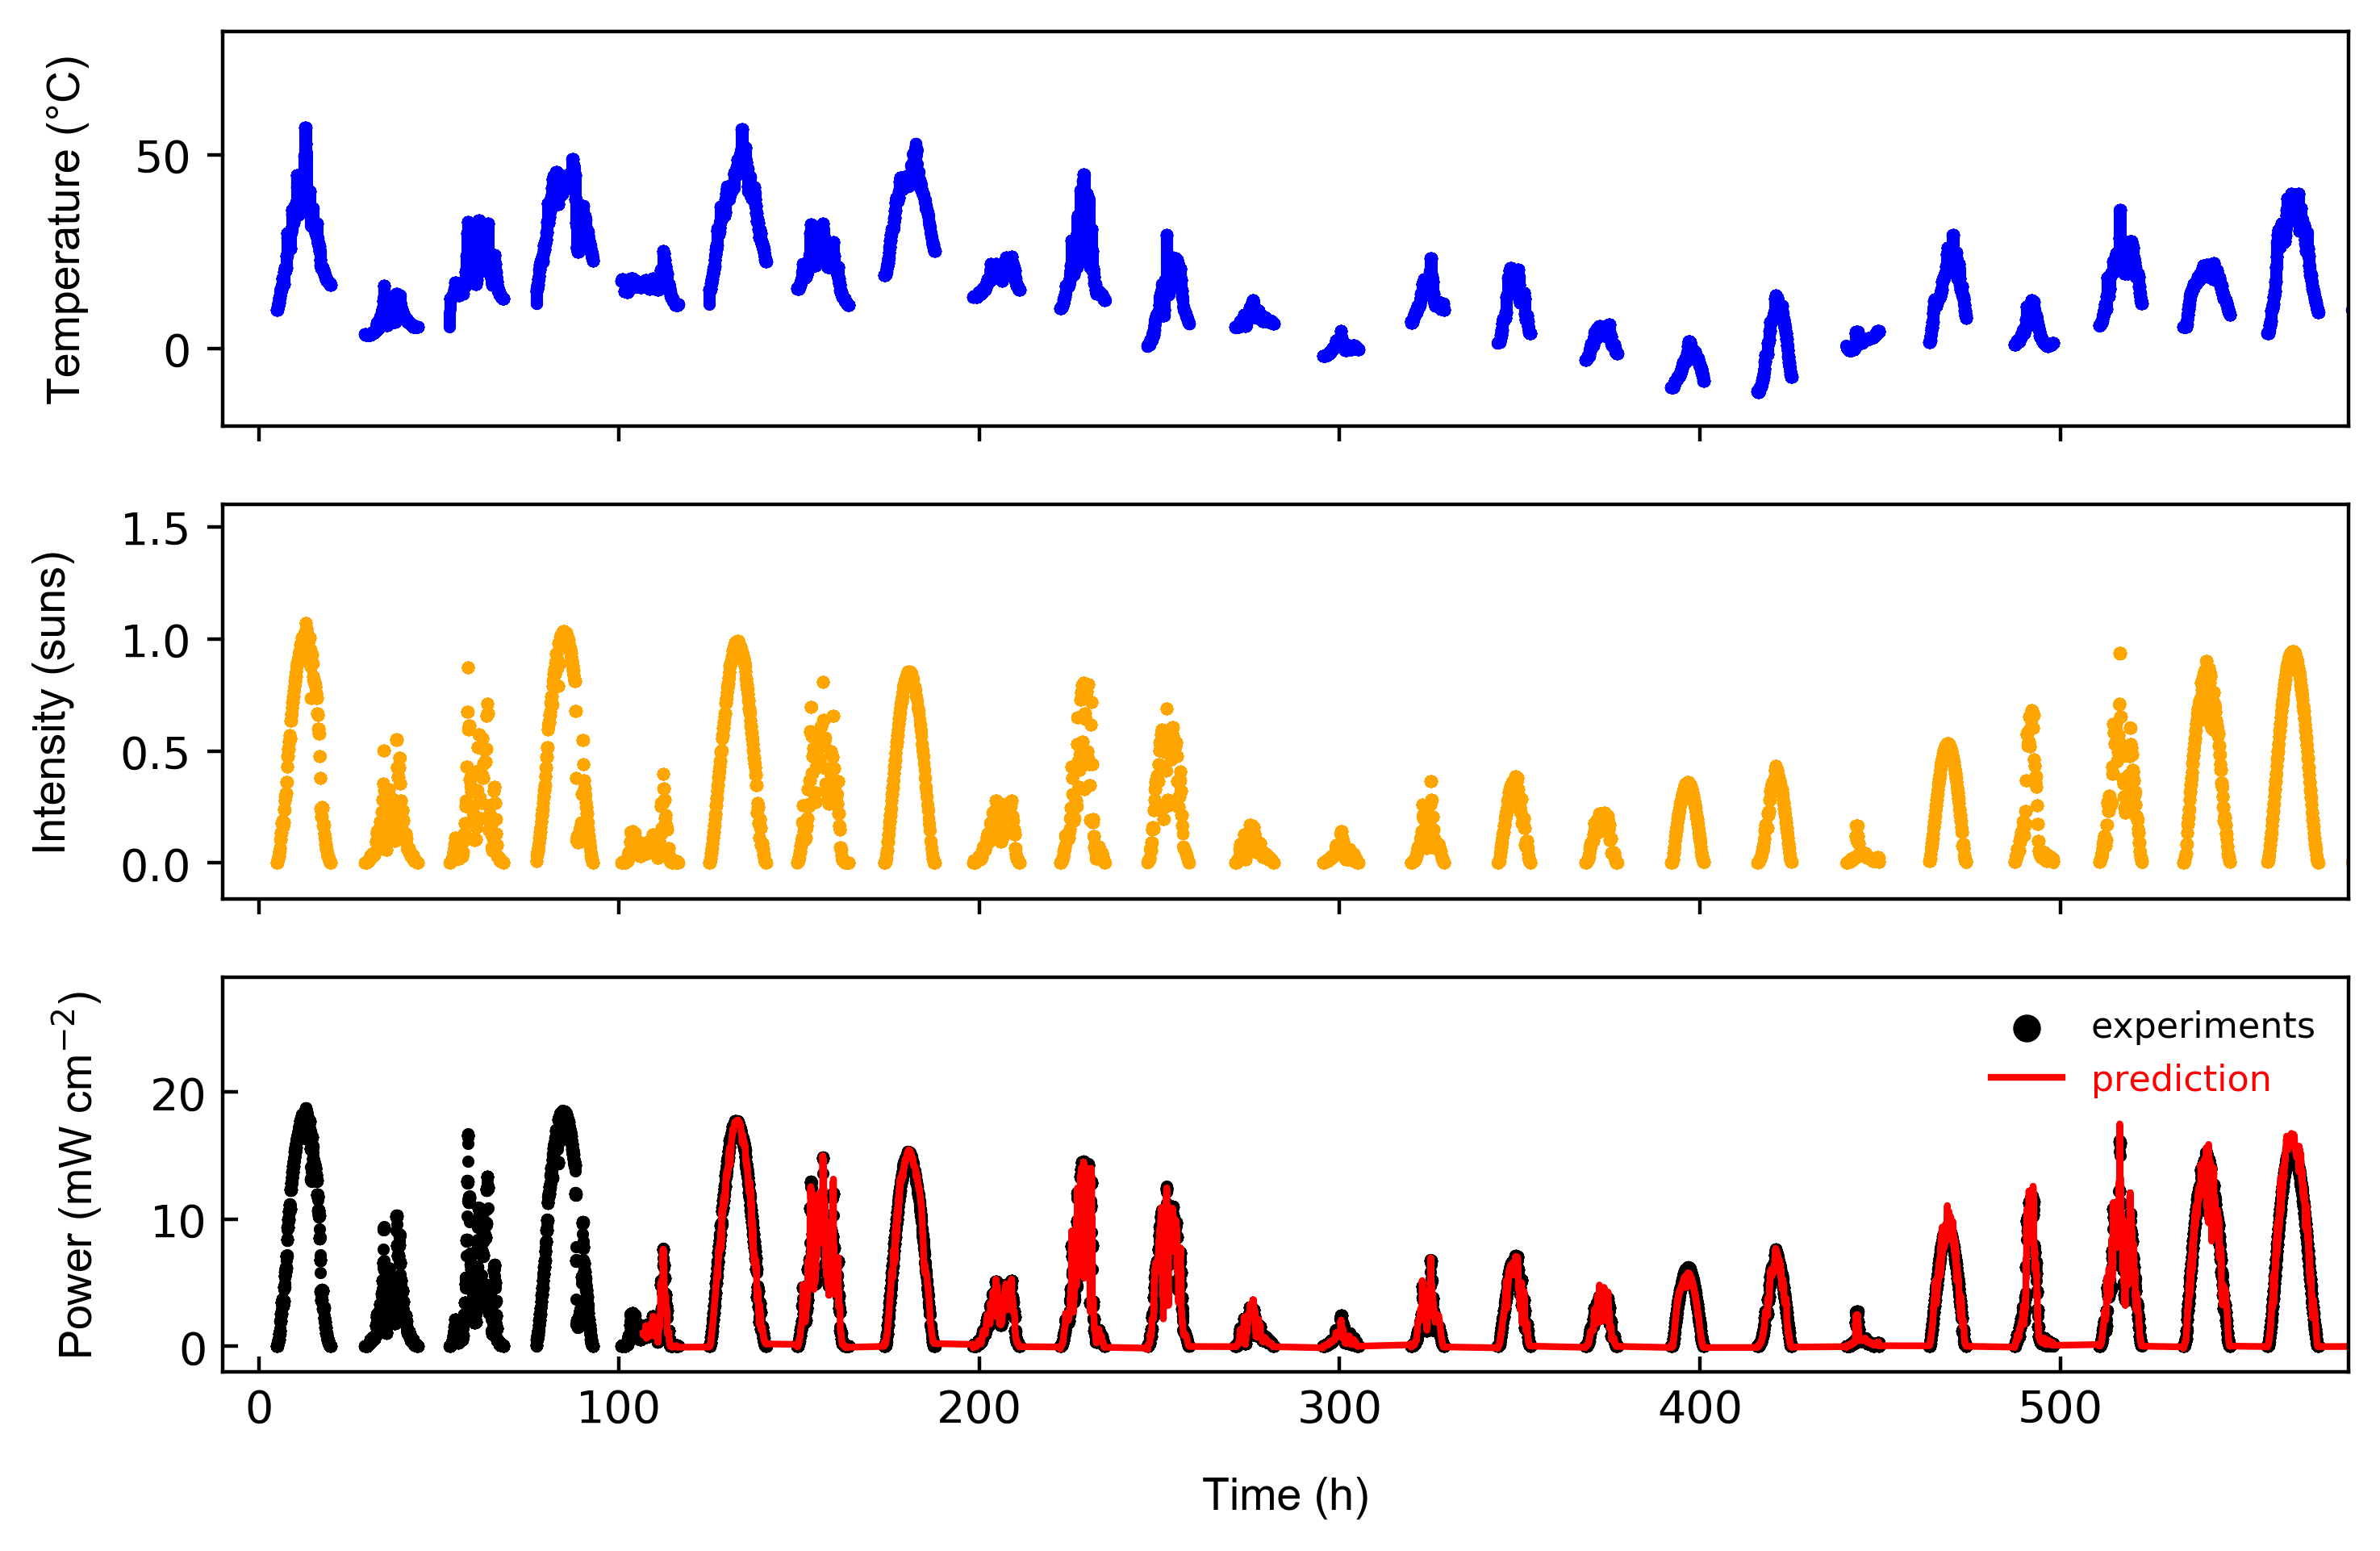

In [6]:
# Plot the results
fig, axarr = plt.subplots(3, 1, sharex='col')
fig.dpi = 400
fig.set_size_inches((8.5, 5.5))

times = np.array(df.iloc[:, [0]])
marker_size = 3
TIME_BOUND = 580

ax_left = axarr[0] # Plot temperature on top sub-plot
temp = temp_scaler.inverse_transform(df[['temperature']])
ax_left.scatter(times, temp_scaler.inverse_transform(df[['temperature']]), s=marker_size, c='blue')
ax_left.set_ylim(-20, 82)
ax_left.set_xlim(-10, TIME_BOUND)
ax_left.set_ylabel(r'Temperature (°C)', labelpad=10, **plot_font_dict)

ax_left = axarr[1] # Plot intensity on middle sub-plot
ax_left.set_ylim(-0.16, 1.6)
ax_left.set_xlim(-10, TIME_BOUND)
intensity = intensity_scaler.inverse_transform(df[['intensity']])
ax_left.scatter(times, intensity_scaler.inverse_transform(df[['intensity']]), s=marker_size, c='orange')
ax_left.set_ylabel(r'Intensity (suns)', labelpad=10, **plot_font_dict)

ax_left = axarr[2] # Plot power (and ESN prediction) on bottom sub-plot
power = power_scaler.inverse_transform(df[['power']])
time_data = df.iloc[:, [0]]
ax_left.scatter(time_data, power, s=marker_size, c='black', label='experiments')
ax_left.plot(time_data[len(trainX):], power_prediction, ls='solid', c='red', label='prediction')

ax_left.set_ylim(-2, 29)
ax_left.set_xlim(-10, TIME_BOUND)
ax_left.set_ylabel(r'Power (mW cm$^{-2}$)', labelpad=10, **plot_font_dict)

ax = ax_left
ax.legend(fontsize=8, frameon=False, markerscale=3)
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0]]
labels = [labels[1], labels[0]]
leg = ax.legend(handles, labels, fontsize=8, frameon=False, markerscale=3)

for handle, text in zip(leg.legendHandles, leg.get_texts()):
    try:
        text.set_color(handle.get_facecolor()[0])
    except AttributeError:
        text.set_color('red')

ax_left.set_xlabel('Time (h)', labelpad=10, **plot_font_dict)

ax_left.tick_params(axis='y', which='both', direction='in')
ax_left.tick_params(axis='x', which='both', direction='in')